# Подготовка

In [ ]:
!pip install biopython

In [ ]:
!wget github.com/arq5x/bedtools2/releases/download/v2.30.0/bedtools-2.30.0.tar.gz
!tar -zxvf bedtools-2.30.0.tar.gz
!cd bedtools2; make
!cp /content/bedtools2/bin/* /usr/local/bin/

In [3]:
from collections import defaultdict
from itertools import product # https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D1%8F%D0%BC%D0%BE%D0%B5_%D0%BF%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
from torch import nn

In [4]:
# Set a random seed in a bunch of different places
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Random seed set as {seed}")
    
set_seed(17)

Random seed set as 17


In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [ ]:
!pip install gtfparse
import gtfparse as gp

# Загрузка и подготовка данных

Загружаем геном и длины хромосом:

In [ ]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/genes/hg19.knownGene.gtf.gz 
!gzip -d hg19.knownGene.gtf.gz

Загружаем даннные разрывов. Используются данные ICGC 25-го релиза

In [7]:
!wget https://raw.githubusercontent.com/xen234/cancer-genome-bp-backup/main/data/raw/blood_all_data.csv
!wget https://raw.githubusercontent.com/xen234/cancer-genome-bp-backup/main/data/raw/brain_all_data.csv
!wget https://raw.githubusercontent.com/xen234/cancer-genome-bp-backup/main/data/raw/lungs_all_data_SBS.csv
!wget https://github.com/xen234/cancer-genome-bp-backup/raw/main/data/raw/lungs_all_data_CNSM.zip

--2023-05-21 20:31:38--  https://raw.githubusercontent.com/xen234/cancer-genome-bp-backup/main/data/raw/blood_all_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262410 (256K) [text/plain]
Saving to: ‘blood_all_data.csv’

blood_all_data.csv  100%[===================>] 256.26K  --.-KB/s    in 0.005s  

2023-05-21 20:31:38 (49.6 MB/s) - ‘blood_all_data.csv’ saved [262410/262410]

--2023-05-21 20:31:38--  https://raw.githubusercontent.com/xen234/cancer-genome-bp-backup/main/data/raw/brain_all_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting re

In [9]:
lung_data = pd.read_csv('lungs_all_data_SBS.csv')
blood_data = pd.read_csv('blood_all_data.csv')
brain_data = pd.read_csv('brain_all_data.csv')

In [10]:
liver_data = pd.read_csv('brain_all_data.csv')
liver_data

,icgc_donor_id,icgc_sample_id,variant_type,chr,chr_bkpt,chr_range,chr_bkpt_beg,chr_bkpt_end
0,DO36167,SA413928,tandem duplication,7,138539032,0,138539032,138539032
1,DO36151,SA413912,reciprocal translocation,6,163987396,0,163987396,163987396
2,DO36143,SA413904,tandem duplication,7,138537675,0,138537675,138537675
3,DO36159,SA413920,tandem duplication,7,138548514,0,138548514,138548514
4,DO36155,SA413916,tandem duplication,7,138541988,0,138541988,138541988
...,...,...,...,...,...,...,...,...
1559,DO35587,SA413662,complex intrachromosomal rearrangement,18,44778253,0,44778253,44778253
1560,DO35587,SA413662,complex intrachromosomal rearrangement,5,14314337,0,14314337,14314337
1561,DO35587,SA413662,intrachromosomal amplicon-to-amplicon,X,91194619,0,91194619,91194619
1562,DO35587,SA413662,tandem duplication,18,6953106,0,6953106,6953106


In [ ]:
lung_data.head()

,icgc_donor_id,icgc_sample_id,variant_type,chr,chr_bkpt,chr_range,chr_bkpt_beg,chr_bkpt_end
0,DO51591,SA534353,interchromosomal rearrangement - unknown type,1,84945093,0,84945093,84945093
1,DO51591,SA534353,interchromosomal rearrangement - unknown type,1,84945093,0,84945093,84945093
2,DO51591,SA534353,interchromosomal rearrangement - unknown type,3,179592240,0,179592240,179592240
3,DO51591,SA534353,interchromosomal rearrangement - unknown type,3,179592240,0,179592240,179592240
4,DO51591,SA534353,interchromosomal rearrangement - unknown type,3,179592240,0,179592240,179592240


Скачали данные разрывов, данные легких также были обработаны, теперь нам нужны еще геномы, размеры хромосом и соответствующие омиксные данные

In [11]:
!head hg19.chrom.sizes

chr1	249250621
chr2	243199373
chr3	198022430
chr4	191154276
chr5	180915260
chr6	171115067
chr7	159138663
chrX	155270560
chr8	146364022
chr9	141213431


In [12]:
genome_df = pd.read_csv("hg19.knownGene.gtf", sep='\t', comment='#', header=None)

In [ ]:
import gzip
import shutil
with gzip.open('copy_number_somatic_mutation.LUSC-US.tsv.gz', 'rb') as f_in:
    with open('file.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

tsv_file='file.tsv'
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('lungs_second.csv',index=False)

large_lung_data = pd.read_csv('lungs_second.csv')
large_lung_data

Отсортируем геном

In [13]:
!grep -P "^chr[0-9,X,Y,M][0-9]?\t" hg19.chrom.sizes > hg19.canon.genome
!grep -P "^chr[0-9,X,Y,M][0-9]?\t" hg19.knownGene.gtf > hg19.canon.gtf
!head hg19.canon.gtf

chr1	knownGene	transcript	11874	14409	.	+	.	gene_id "uc001aaa.3"; transcript_id "uc001aaa.3"; 
chr1	knownGene	exon	11874	12227	.	+	.	gene_id "uc001aaa.3"; transcript_id "uc001aaa.3"; exon_number "1"; exon_id "uc001aaa.3.1";
chr1	knownGene	exon	12613	12721	.	+	.	gene_id "uc001aaa.3"; transcript_id "uc001aaa.3"; exon_number "2"; exon_id "uc001aaa.3.2";
chr1	knownGene	exon	13221	14409	.	+	.	gene_id "uc001aaa.3"; transcript_id "uc001aaa.3"; exon_number "3"; exon_id "uc001aaa.3.3";
chr1	knownGene	transcript	11874	14409	.	+	.	gene_id "uc010nxr.1"; transcript_id "uc010nxr.1"; 
chr1	knownGene	exon	11874	12227	.	+	.	gene_id "uc010nxr.1"; transcript_id "uc010nxr.1"; exon_number "1"; exon_id "uc010nxr.1.1";
chr1	knownGene	exon	12646	12697	.	+	.	gene_id "uc010nxr.1"; transcript_id "uc010nxr.1"; exon_number "2"; exon_id "uc010nxr.1.2";
chr1	knownGene	exon	13221	14409	.	+	.	gene_id "uc010nxr.1"; transcript_id "uc010nxr.1"; exon_number "3"; exon_id "uc010nxr.1.3";
chr1	knownGene	transcript	11874	1440

In [14]:
!bedtools sort -i <(grep -P "^chr[0-9,X,Y,M][0-9]?\t" hg19.knownGene.gtf) -g hg19.canon.genome > genome_sorted.gtf

In [15]:
sorted_genome_df = pd.read_csv("genome_sorted.gtf", sep='\t', comment='#', header=None)
sorted_genome_df

,0,1,2,3,4,5,6,7,8
0,chr1,knownGene,exon,11874,12227,.,+,.,"gene_id ""uc001aaa.3""; transcript_id ""uc001aaa...."
1,chr1,knownGene,transcript,11874,14409,.,+,.,"gene_id ""uc001aaa.3""; transcript_id ""uc001aaa...."
2,chr1,knownGene,5UTR,11874,12189,.,+,.,"gene_id ""B7ZGX9""; transcript_id ""uc010nxq.1""; ..."
3,chr1,knownGene,exon,11874,12227,.,+,.,"gene_id ""B7ZGX9""; transcript_id ""uc010nxq.1""; ..."
4,chr1,knownGene,transcript,11874,14409,.,+,.,"gene_id ""B7ZGX9""; transcript_id ""uc010nxq.1""; ..."
...,...,...,...,...,...,...,...,...,...
1645590,chrM,knownGene,exon,15504,15888,.,-,.,"gene_id ""uc022bqs.1""; transcript_id ""uc022bqs...."
1645591,chrM,knownGene,transcript,15960,16024,.,-,.,"gene_id ""uc022bqx.1""; transcript_id ""uc022bqx...."
1645592,chrM,knownGene,exon,15960,16024,.,-,.,"gene_id ""uc022bqx.1""; transcript_id ""uc022bqx...."
1645593,chrM,knownGene,transcript,15999,16571,.,+,.,"gene_id ""uc004coz.1""; transcript_id ""uc004coz...."


# Фильтрация данных по геному

In [ ]:
!pip install pybedtools
from pybedtools import BedTool

<Axes: xlabel='chr'>

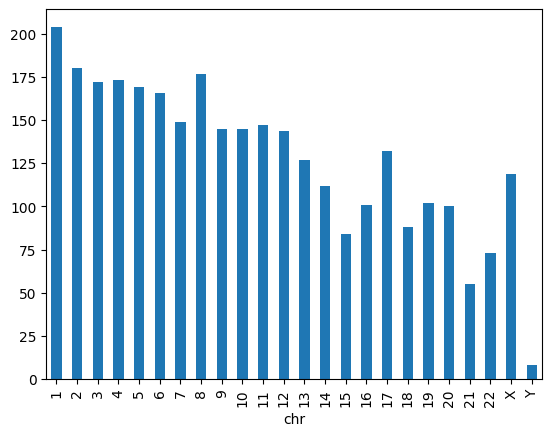

In [ ]:
from natsort import natsorted 
distr=liver_data.groupby('chr')['icgc_sample_id'].nunique()

distr.reindex(index = natsorted(distr.index)).plot(kind="bar")

<Axes: xlabel='chr'>

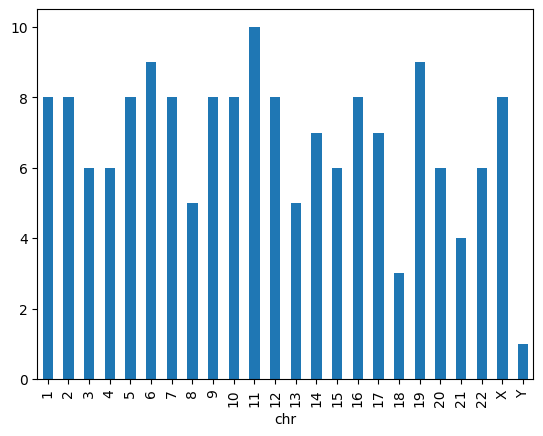

In [ ]:
from natsort import natsorted 
distr=lung_data.groupby('chr')['icgc_sample_id'].nunique()

distr.reindex(index = natsorted(distr.index)).plot(kind="bar")

In [ ]:
!wget https://github.com/Boyle-Lab/Blacklist/raw/master/lists/hg19-blacklist.v2.bed.gz
!gzip -d hg19-blacklist.v2.bed.gz
!head hg19-blacklist.v2.bed

In [ ]:
liver_data.columns

Index(['icgc_donor_id', 'icgc_sample_id', 'variant_type', 'chr', 'chr_bkpt',
       'chr_range', 'chr_bkpt_beg', 'chr_bkpt_end'],
      dtype='object')

In [19]:
new_order = ['chr', 'chr_bkpt_beg', 'chr_bkpt_end', 'icgc_donor_id', 'icgc_sample_id', 'variant_type', 'chr_bkpt',
       'chr_range']
liver_data = liver_data[new_order]
liver_data['chr'] = liver_data['chr'].apply(lambda x: 'chr' + x)
liver_data.head()

,chr,chr_bkpt_beg,chr_bkpt_end,icgc_donor_id,icgc_sample_id,variant_type,chr_bkpt,chr_range
0,chr7,138539032,138539032,DO36167,SA413928,tandem duplication,138539032,0
1,chr6,163987396,163987396,DO36151,SA413912,reciprocal translocation,163987396,0
2,chr7,138537675,138537675,DO36143,SA413904,tandem duplication,138537675,0
3,chr7,138548514,138548514,DO36159,SA413920,tandem duplication,138548514,0
4,chr7,138541988,138541988,DO36155,SA413916,tandem duplication,138541988,0


In [20]:
brain_data = brain_data[new_order]
brain_data['chr'] = brain_data['chr'].apply(lambda x: 'chr' + x)
brain_data.head()

,chr,chr_bkpt_beg,chr_bkpt_end,icgc_donor_id,icgc_sample_id,variant_type,chr_bkpt,chr_range
0,chr7,138539032,138539032,DO36167,SA413928,tandem duplication,138539032,0
1,chr6,163987396,163987396,DO36151,SA413912,reciprocal translocation,163987396,0
2,chr7,138537675,138537675,DO36143,SA413904,tandem duplication,138537675,0
3,chr7,138548514,138548514,DO36159,SA413920,tandem duplication,138548514,0
4,chr7,138541988,138541988,DO36155,SA413916,tandem duplication,138541988,0


In [21]:
breakpoints = BedTool.from_dataframe(liver_data)
filtered_breakpoints = breakpoints.intersect("hg19-blacklist.v2.bed", v=True)

In [22]:
sorted_genome_df = pd.DataFrame(sorted_genome_df)
sorted_genome_df.drop([1, 2], inplace=True, axis=1)
sorted_genome = BedTool.from_dataframe(sorted_genome_df)
filtered_breakpoints = filtered_breakpoints.intersect(sorted_genome, u=True)

In [23]:
filtered_breakpoints.head()

chr7	138539032	138539032	DO36167	SA413928	tandem duplication	138539032	0
 chr6	163987396	163987396	DO36151	SA413912	reciprocal translocation	163987396	0
 chr7	138537675	138537675	DO36143	SA413904	tandem duplication	138537675	0
 chr7	138548514	138548514	DO36159	SA413920	tandem duplication	138548514	0
 chr7	138541988	138541988	DO36155	SA413916	tandem duplication	138541988	0
 chr7	138537319	138537319	DO36127	SA413888	tandem duplication	138537319	0
 chr1	11870279	11870279	DO36123	SA413884	reciprocal translocation	11870279	0
 chr7	138543923	138543923	DO36139	SA413900	tandem duplication	138543923	0
 chr7	138541805	138541805	DO36135	SA413896	tandem duplication	138541805	0
 chr7	138545823	138545823	DO36131	SA413892	tandem duplication	138545823	0
 

In [24]:
filtered_liver_df = filtered_breakpoints.to_dataframe()
filtered_liver_df.columns = new_order
filtered_liver_df

,chr,chr_bkpt_beg,chr_bkpt_end,icgc_donor_id,icgc_sample_id,variant_type,chr_bkpt,chr_range
0,chr7,138539032,138539032,DO36167,SA413928,tandem duplication,138539032,0
1,chr6,163987396,163987396,DO36151,SA413912,reciprocal translocation,163987396,0
2,chr7,138537675,138537675,DO36143,SA413904,tandem duplication,138537675,0
3,chr7,138548514,138548514,DO36159,SA413920,tandem duplication,138548514,0
4,chr7,138541988,138541988,DO36155,SA413916,tandem duplication,138541988,0
...,...,...,...,...,...,...,...,...
744,chr17,48940606,48940606,DO35587,SA413662,deletion,48940606,0
745,chr2,51065148,51065148,DO35587,SA413662,complex intrachromosomal rearrangement,51065148,0
746,chr5,14314337,14314337,DO35587,SA413662,complex intrachromosomal rearrangement,14314337,0
747,chrX,91194619,91194619,DO35587,SA413662,intrachromosomal amplicon-to-amplicon,91194619,0


In [ ]:
filtered_liver_df.to_csv('filtered_liver_data.csv', index=False)

In [ ]:
breakpoints = BedTool.from_dataframe(brain_data)
filtered_breakpoints = breakpoints.intersect("hg19-blacklist.v2.bed", v=True)

sorted_genome_df = pd.DataFrame(sorted_genome_df)
sorted_genome = BedTool.from_dataframe(sorted_genome_df)
filtered_breakpoints = filtered_breakpoints.intersect(sorted_genome, u=True)

filtered_lungs_df = filtered_breakpoints.to_dataframe()
filtered_lungs_df.columns = new_order

In [ ]:
ord = ['chr', 'chr_bkpt_beg', 'chr_bkpt_end']
filtered_lungs_df = filtered_lungs_df[ord]
bed_object = BedTool.from_dataframe(filtered_lungs_df)
bed_object.saveas('filtered_brain_data.bed')

In [ ]:
filtered_liver_df.bed_object.saveas('output.bed')

In [ ]:
bed_object.head()

chr1	84945093	84945093
 chr1	84945093	84945093
 chr3	179592240	179592240
 chr3	179592240	179592240
 chr3	179592240	179592240
 chr3	179592240	179592240
 chr3	179592240	179592240
 chr3	179592240	179592240
 chr3	179592240	179592240
 chr3	179592240	179592240
 

In [ ]:
bed_object.saveas('output.bed')

In [ ]:
bed_string = filtered_lungs_df.to_csv(index=False, header=True, sep=',')
with open('filt_lungs.bed', 'w') as file:
    file.write(bed_string)